## Problem Statement

In recent years, the advancement of computer vision techniques, particularly deep learning algorithms, has revolutionized various fields, including automotive safety and insurance assessment. 
This project proposes the implementation of Mask R-CNN (Region-based Convolutional Neural Network) for the detection and segmentation of car damages in images. The objective is to develop 
an efficient and accurate system capable of automatically identifying and delineating different types of damages such as scratches, dents, and cracks on car surfaces.

## About the data

About 64 Car Images with Scratches and Dents were downloaded from Google for creating a model for damage segmentation. 49 images were considered for training and 14 images were considered for Validation and testing. These downloaded images were annotated using an online tool - LABELBox. These annotations were extracted in the JSON format for each group - Training and Validation.  

## Importing Necessary libraries

In [1]:
import json # Used tp read json files
import cv2 # Used to implement computer vision operations
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Used to implement faster RCNN within Mask RCNN
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor # Used to implement Mask RCNN predictor
from imutils.paths import list_images # Used to list image inside a directory
import matplotlib.pyplot as plt # Used for data visualisation
from engine import train_one_epoch, evaluate # Used to train and evaluate the Mask RCNN model
import torch # Used for torch framework operations
import numpy as np # Used for array operations
import warnings # Used to filter warnings
import utils # Used to implement utility functions
import torchvision # Used to implement mask_resnet50 detection model
from torchvision import tv_tensors # Used to convert torchvision to torch tensors
from torchvision.ops.boxes import masks_to_boxes # Used to extract boxes from mask images
from torchvision.transforms.v2 import functional as F # Used to implement functional methods
from torchvision.transforms import v2 as T # Used to implement transformations on the dataset
import torch.utils.data # Used for implement torch data loader
from ultralytics import YOLO # Used to create a YOLO segmentation model

#Filter the warnings
warnings.filterwarnings("ignore")


## Loading the Training Data

In [5]:
# Loading the Json data extracted from Label box
with open('Dataset/train/train_json.json') as f:
    target = json.load(f)

In [6]:
target #View the training data

{'image1.jpeg4794': {'filename': 'image1.jpeg',
  'size': 4794,
  'regions': [{'shape_attributes': {'name': 'polygon',
     'all_points_x': [101, 182, 220, 192, 103, 79, 98],
     'all_points_y': [41, 33, 45, 123, 127, 69, 40]},
    'region_attributes': {'name': 'damage',
     'type': 'unknown',
     'image_quality': {'good': True,
      'frontal': True,
      'good_illumination': True}}}],
  'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}},
 'image2.jpg70052': {'filename': 'image2.jpg',
  'size': 70052,
  'regions': [{'shape_attributes': {'name': 'polygon',
     'all_points_x': [186,
      96,
      138,
      181,
      421,
      636,
      746,
      765,
      758,
      741,
      689,
      655,
      505,
      417,
      338,
      295,
      221,
      186],
     'all_points_y': [327,
      355,
      229,
      225,
      94,
      60,
      134,
      177,
      206,
      185,
      181,
      142,
      141,
      166,
      194,
      226,
    

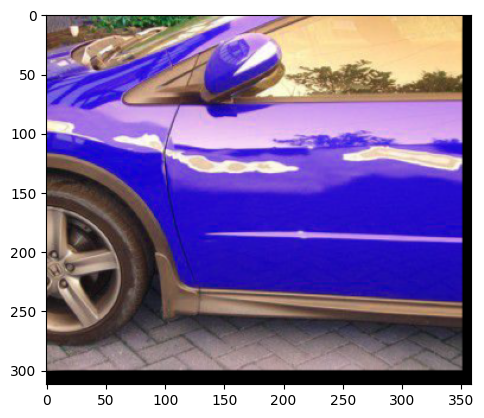

In [50]:
# Plot an image from the Train Directory
plt.imshow(cv2.imread("Dataset/train/image6.png"))
plt.show()

In [63]:
mask_list = [] # Create a list for mask images
img_list = []  # Create a list for original images
filename_list = [] # Create a list for filenames
# Iterating through each image
for t in target.values():
    img = cv2.imread(f"Dataset/train/{t['filename']}") # Read the image
    img_list.append(img) #Appending the image to the list
    filename_list.append(t["filename"]) #Appending the filename to the list
    mask = np.zeros(shape = img.shape[:2], dtype= np.int32) # Creating a mask image with the same of the image (Gray Scale image)
    #Iterating through every Region of Interest within an image
    for i in t["regions"]:
        polygon = [] # Create a list to draw a polygon 
        # Generating the coordinates of the polygon
        for x, y in zip(i['shape_attributes']['all_points_x'], i['shape_attributes']['all_points_y']):
            polygon.append([x,y]) # Append each (x,y) coordinate of the polygon
        polygon = np.array(polygon, np.int32) # Converting the list into an array
        pts = polygon.reshape((-1,1,2)) # Reshaping the polygon
        mask = cv2.drawContours(mask, [pts], -1, 255 , -1) # Drawing the polygon on the mask image
    
    mask_list.append(np.array(mask)) # Appending every mask image to the list

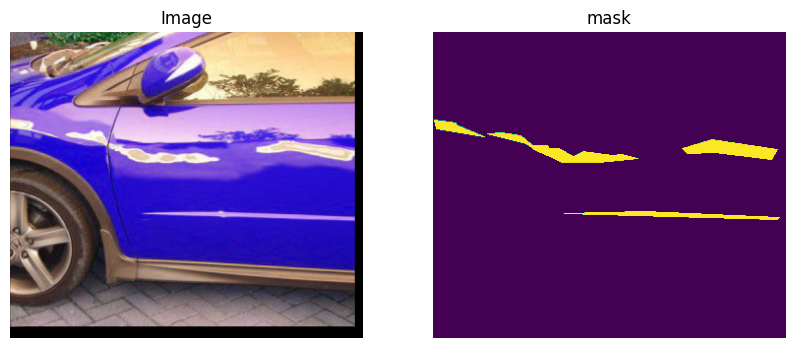

In [71]:
# View the original and mask image
index = 5
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 2) # Creating a subplot to view the original and mask image
ax[0].imshow(img_list[index]) # Plot the original image
ax[0].set_title("Image") # Configure the title of the original image
ax[0].axis("off") # Removing the axis of the original image
ax[1].imshow(mask_list[index]) # Plot the mask image
ax[1].set_title("mask") # Configure the title of the mask image
ax[1].axis("off") # Removing the axis from the mask image
plt.show()

## Validation Data

In [72]:
# Loading the Json data extracted from Label box
with open('Dataset/val/val_json.json') as f:
    target_val = json.load(f)

In [73]:
target_val #View the training data

{'image61.jpeg7872': {'filename': 'image61.jpeg',
  'size': 7872,
  'regions': [{'shape_attributes': {'name': 'polygon',
     'all_points_x': [139, 120, 130, 147, 167, 164, 153, 141, 136, 133],
     'all_points_y': [124, 121, 93, 70, 67, 82, 103, 110, 118, 120]},
    'region_attributes': {'name': 'damage',
     'type': 'unknown',
     'image_quality': {'good': True,
      'frontal': True,
      'good_illumination': True}}}],
  'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}},
 'image62.jpg115110': {'filename': 'image62.jpg',
  'size': 115110,
  'regions': [{'shape_attributes': {'name': 'polygon',
     'all_points_x': [283,
      256,
      217,
      265,
      353,
      550,
      654,
      668,
      636,
      553,
      592,
      446,
      294],
     'all_points_y': [492,
      448,
      430,
      419,
      424,
      406,
      424,
      479,
      548,
      568,
      514,
      498,
      510]},
    'region_attributes': {'name': 'damage',
    

In [ ]:
# Iterating through each image
for t in target_val.values():
    img = cv2.imread(f"Dataset/val/{t['filename']}") # Read the image
    img_list.append(img) #Appending the image to the list
    filename_list.append(t["filename"]) #Appending the filename to the list
    mask = np.zeros(shape = img.shape[:2], dtype= np.int32) # Creating a mask image with the same of the image (Gray Scale image)
    #Iterating through every Region of Interest within an image
    for i in t["regions"]:
        polygon = [] # Create a list to draw a polygon 
        # Generating the coordinates of the polygon
        for x, y in zip(i['shape_attributes']['all_points_x'], i['shape_attributes']['all_points_y']):
            polygon.append([x,y]) # Append each (x,y) coordinate of the polygon
        polygon = np.array(polygon, np.int32) # Converting the list into an array
        pts = polygon.reshape((-1,1,2)) # Reshaping the polygon
        mask = cv2.drawContours(mask, [pts], -1, 255 , -1) # Drawing the polygon on the mask image
    
    mask_list.append(np.array(mask)) # Appending every mask image to the list

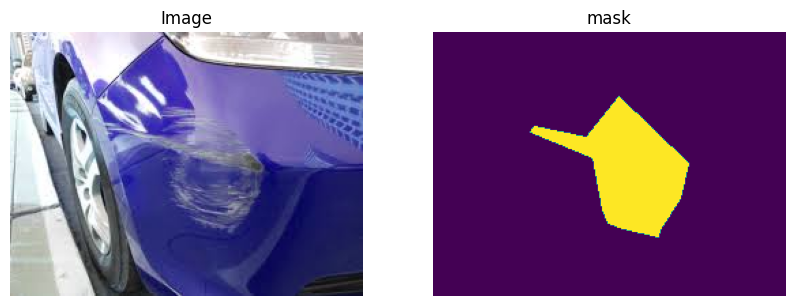

In [77]:
# View the original and mask image
index = 5
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 2) # Creating a subplot to view the original and mask image
ax[0].imshow(img_list[-index]) # Plot the original image
ax[0].set_title("Image") # Configure the title of the original image
ax[0].axis("off") # Removing the axis of the original image
ax[1].imshow(mask_list[-index]) # Plot the mask image
ax[1].set_title("mask") # Configure the title of the mask image
ax[1].axis("off") # Removing the axis from the mask image
plt.show()

In [16]:
len(img_list), len(mask_list), len(filename_list) # View the length of each list

(64, 64, 64)

## Model Training and Evaluation 

In [17]:
class CarDamageDataset(torch.utils.data.Dataset):
    def __init__(self, image_list , mask_list, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.mask_list = mask_list
        self.image_list = image_list

    def __getitem__(self, idx):
        # load images and masks
        img =  torch.tensor(self.image_list[idx])
        mask = torch.tensor(self.mask_list[idx])

        
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        img = img.permute(2,0,1)
        mask = tv_tensors.Mask(mask)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = mask
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


    def __len__(self):
        return len(self.mask_list)

In [18]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [20]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = CarDamageDataset(img_list[:-50], mask_list[:-50], get_transform(train=True))
dataset_test = CarDamageDataset(img_list[-15:], mask_list[-15:], get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
indices = torch.randperm(len(dataset_test)).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[-2:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and car damage
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.00001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

### MASK RCNN Model Architecture

In [23]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [25]:
# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, "car_damage_detection.pt")

Epoch: [0]  [0/4]  eta: 0:00:01  lr: 0.000003  loss: -264.5549 (-264.5549)  loss_classifier: 0.6825 (0.6825)  loss_box_reg: 0.0882 (0.0882)  loss_mask: -265.3555 (-265.3555)  loss_objectness: 0.0237 (0.0237)  loss_rpn_box_reg: 0.0062 (0.0062)  time: 0.4932  data: 0.0070  max mem: 1592
Epoch: [0]  [1/4]  eta: 0:00:00  lr: 0.000007  loss: -600.2926 (-432.4238)  loss_classifier: 0.6334 (0.6580)  loss_box_reg: 0.0011 (0.0446)  loss_mask: -606.3143 (-435.8349)  loss_objectness: 0.0237 (2.2922)  loss_rpn_box_reg: 0.0062 (0.4164)  time: 0.2861  data: 0.0055  max mem: 1592
Epoch: [0]  [2/4]  eta: 0:00:00  lr: 0.000010  loss: -313.4292 (-392.7589)  loss_classifier: 0.6505 (0.6555)  loss_box_reg: 0.0882 (0.0846)  loss_mask: -314.2518 (-395.3072)  loss_objectness: 0.0237 (1.5290)  loss_rpn_box_reg: 0.0062 (0.2792)  time: 0.2381  data: 0.0164  max mem: 1592
Epoch: [0]  [3/4]  eta: 0:00:00  lr: 0.000010  loss: -600.2926 (-493.3763)  loss_classifier: 0.6334 (0.6293)  loss_box_reg: 0.0428 (0.0741)  l

In [3]:
#Extracting list of images from the validation directory
val_list = list(list_images("Dataset/val"))
val_list, len(val_list)

(['Dataset/val\\image61.jpeg',
  'Dataset/val\\image62.jpg',
  'Dataset/val\\image63.jpg',
  'Dataset/val\\image64.jpg',
  'Dataset/val\\image65.jpg',
  'Dataset/val\\image72.jpeg',
  'Dataset/val\\image73.jpg',
  'Dataset/val\\image74.jpeg',
  'Dataset/val\\image75.jpeg',
  'Dataset/val\\image75.jpg',
  'Dataset/val\\image76.jpg',
  'Dataset/val\\image77.jpg',
  'Dataset/val\\image78.jpg',
  'Dataset/val\\image79.jpg',
  'Dataset/val\\image80.jpg'],
 15)

### Model Inference


image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image61.jpeg: 384x640 (no detections), 153.8ms
Speed: 3.0ms preprocess, 153.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\segment\predict2

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image62.jpg: 480x640 2 damages, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 12.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\segment\predict2

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image63.jpg: 448x640 2 damages, 142.5ms
Speed: 1.0ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\segment\predict2

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image64.jpg: 448x640 1 damage, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\segment\predict2

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image65.j

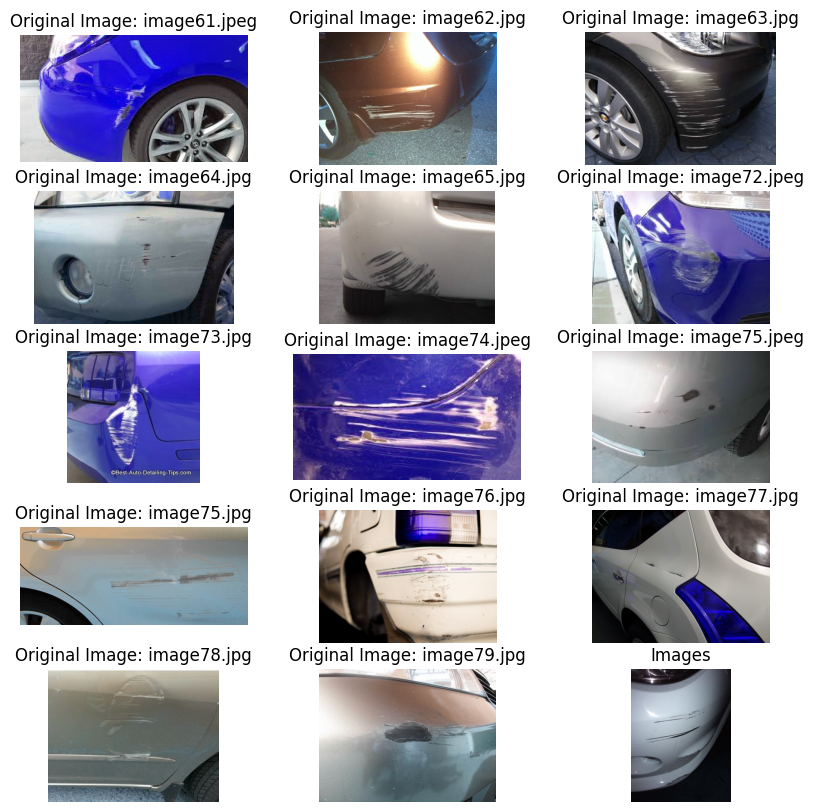

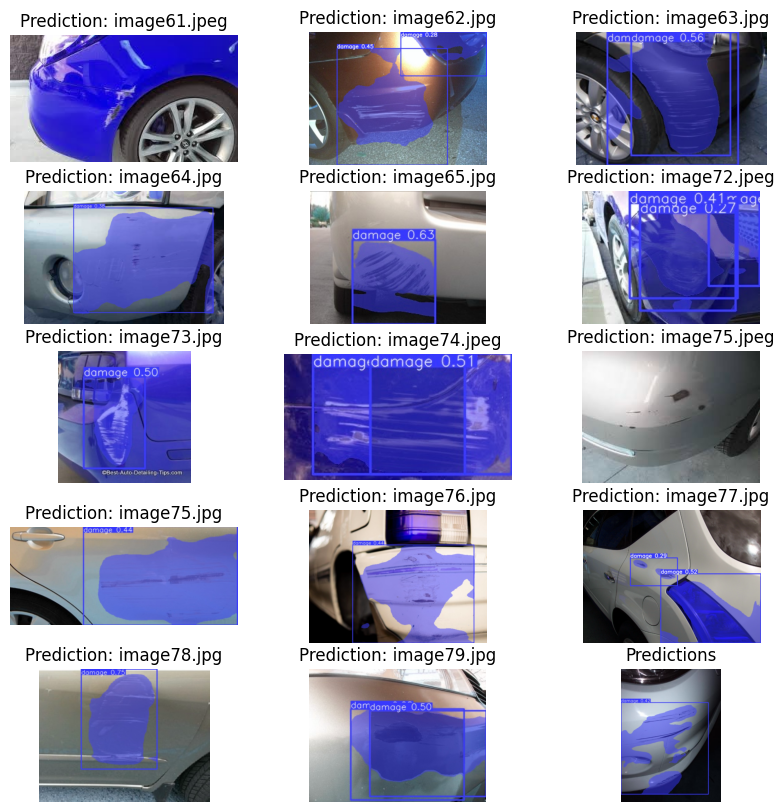

In [7]:
imgs = [i.split(sep = "\\")[-1] for i in val_list] # Create a list with all the image names within the validation directory
fig, ax = plt.subplots(figsize = (10,10), nrows = 5, ncols = 3) # Create a subplot to plot the original images
# Iterating through each image
for i,j in zip(imgs, ax.flatten()): 
    results = model.predict(f"Dataset/val/{i}", save = True, save_dir = "runs/segment/predict2") # Predicting the car damage and saving the image to a directory
    j.imshow(cv2.imread(f"Dataset/val/{i}")) # Plotting the original image
    j.set_title(f"Original Image: {i}") # Configuring the title
    j.axis("off") # Removing the axis
plt.title("Images") # Title of the plot

fig, ax = plt.subplots(figsize = (10,10), nrows = 5, ncols = 3) # Create a subplot to plot the predicted images
# Iterating over each predicted image
for i,j in zip(imgs, ax.flatten()):
    j.imshow(cv2.imread(f"runs/segment/predict2/{i}")) # Reading the predicted image
    j.set_title(f"Prediction: {i}") #Configuring the title
    j.axis("off") # Removing the axis
plt.title("Predictions") # Title of the plot
plt.show()

Although model was able to predict damage segments on the validation images, there are few areas where the model incorrectly classifies objects as damages (For eg: Tail lights, Wheels, etc.). To overcome this problem we can finetune a pretrained segmentation model(YOLO)

## Finetuning a YOLO model (Open source pretrained segmentation model)

To finetune a yolo segmentation model, I have utilized a different annotation tool - ROBOFLOW and generated a yaml file for the same.

In [2]:
model = YOLO("yolov8m-seg.pt") # Initialising the yolo segmentation model
model.train(data = "datasets/data.yaml", epochs = 100, workers=1) # Training the segmentation model

New https://pypi.org/project/ultralytics/8.1.33 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
engine\trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=datasets/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

train: Scanning C:\Users\diljy\Desktop\Mask_RCNN\datasets\train\labels.cache... 43 images, 0 backgrounds, 3 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]

train: WARNING ⚠️ C:\Users\diljy\Desktop\Mask_RCNN\datasets\train\images\image10_jpg.rf.b628209072ce7b1df0b26662bbee8916.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1888      1.1196]
train: WARNING ⚠️ C:\Users\diljy\Desktop\Mask_RCNN\datasets\train\images\image2_jpg.rf.72b5acff668bb6eb25b045231568432d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0323]
train: WARNING ⚠️ C:\Users\diljy\Desktop\Mask_RCNN\datasets\train\images\image65_jpg.rf.b2deb9ccb5195567378ec75bfa154ffd.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0438]



val: Scanning C:\Users\diljy\Desktop\Mask_RCNN\datasets\valid\labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]


Plotting labels to runs\segment\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs\segment\train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.14G      2.286       6.02      3.721      2.429         24        640: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         12         20      0.409        0.1      0.056     0.0281      0.215        0.1     0.0256    0.00411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.79G      2.462      6.623      3.893      2.517         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

                   all         12         20      0.466        0.1     0.0785     0.0388      0.245        0.1     0.0335     0.0047



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.81G      2.295      6.293      3.833      2.548         23        640: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         12         20       0.24        0.1     0.0481     0.0309       0.24        0.1     0.0401    0.00891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.03G      2.205      4.091      3.257      2.422         22        640: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         12         20     0.0715       0.15     0.0238    0.00638     0.0386        0.1    0.00693     0.0022



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.72G      1.939      4.007      2.813      2.139         20        640: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

                   all         12         20        0.3        0.1     0.0346    0.00658      0.149       0.05     0.0078    0.00078



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.71G      2.051      3.731      2.755      2.204         18        640: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

                   all         12         20      0.748      0.149      0.116     0.0475      0.748      0.149      0.113     0.0239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.75G       1.97      3.402      2.579      2.172         33        640: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         12         20    0.00711        0.2      0.005    0.00153    0.00096       0.15   0.000557   0.000178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.75G      1.801      3.184      2.433      2.075         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         12         20    0.00653       0.25    0.00453    0.00148    0.00227        0.2   0.000926   0.000198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.74G      1.814      3.301      2.394      2.205         16        640: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]

                   all         12         20     0.0027        0.2    0.00183   0.000495   0.000675       0.05   0.000179   3.58e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.75G      1.822      3.594      2.429      2.125         20        640: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

                   all         12         20    0.00383        0.3     0.0023    0.00039    0.00036       0.05   0.000151   1.51e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.81G      1.948      3.776      2.616      2.145         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         12         20     0.0193       0.15    0.00585    0.00104          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.73G      2.045      3.869      2.493      2.188         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         12         20    0.00848        0.1    0.00235    0.00066    0.00424       0.05    0.00122   0.000306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.74G      1.943      3.435      2.562      2.072         20        640: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

                   all         12         20     0.0111        0.3    0.00791    0.00147   0.000358       0.05    0.00023   0.000115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.75G      1.922      3.331       2.25      2.029         20        640: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         12         20    0.00843       0.35    0.00513    0.00133     0.0012       0.05   0.000224   9.91e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.74G      1.961      3.365      2.381      2.078         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]

                   all         12         20   0.000278       0.05   0.000175   5.38e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.73G      1.928      3.369       2.35      1.994         37        640: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]

                   all         12         20    0.00261       0.45    0.00271   0.000712   0.000871       0.15   0.000979   0.000209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.74G      1.906      3.249      2.216      1.981         29        640: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]

                   all         12         20    0.00694       0.45    0.00726    0.00204    0.00308        0.2    0.00866   0.000981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.07G      1.818      3.604      2.152      2.025         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         12         20     0.0205        0.5     0.0198    0.00565     0.0123        0.3     0.0107    0.00158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.73G      1.942       3.37      2.161      2.079         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

                   all         12         20     0.0134        0.3     0.0121    0.00336    0.00668       0.15    0.00312   0.000533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.05G      1.992      3.452      2.095      2.202         26        640: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         12         20     0.0282        0.3     0.0133    0.00292    0.00939        0.1    0.00182   0.000312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.81G      1.937       3.31       2.19       2.11         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

                   all         12         20    0.00401       0.25    0.00226   0.000498    0.00197        0.1   0.000506   0.000161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.03G      1.877      3.401      2.196      2.111         18        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]

                   all         12         20    0.00294        0.4     0.0027   0.000753     0.0017        0.2    0.00149   0.000329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.76G      1.743      2.905      1.855      1.917         27        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         12         20   0.000747        0.1   0.000326   0.000112   0.000747        0.1   0.000326   8.09e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.06G      1.743      3.136      2.029      2.007         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]

                   all         12         20   0.000367       0.05   0.000166   3.32e-05   0.000367       0.05    0.00016    1.6e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.07G      1.976      3.202      2.021      2.096         29        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         12         20    0.00134       0.15   0.000711   0.000107    0.00134       0.15   0.000711   0.000213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.79G      1.904      3.439      2.276      2.163         21        640: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         12         20     0.0019        0.3    0.00149   0.000271   0.000632        0.1   0.000318   9.67e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.72G      1.747       3.34      1.893      2.027         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         12         20    0.00556        0.4    0.00312   0.000701   0.000695       0.05   0.000408    0.00016



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.11G      1.928      3.492      1.957      2.099         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         12         20    0.00282        0.4    0.00188   0.000421   0.000706        0.1   0.000366   5.16e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.03G       1.87      3.395      2.063      2.037         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         12         20    0.00282        0.4    0.00188   0.000421   0.000706        0.1   0.000366   5.16e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.75G      1.976      3.698      2.404      2.274         17        640: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         12         20    0.00111        0.2    0.00085   0.000197   0.000556        0.1   0.000338   6.76e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.76G      1.874      3.356      2.109      2.033         21        640: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         12         20    0.00252       0.45    0.00219   0.000637    0.00168        0.3    0.00114   0.000326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.78G       1.83      3.288      2.076      1.992         26        640: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         12         20    0.00488       0.35    0.00396    0.00103    0.00157       0.15   0.000966   0.000307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.73G      1.875      3.377      2.043      2.027         22        640: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         12         20    0.00488       0.35    0.00396    0.00103    0.00157       0.15   0.000966   0.000307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.76G      1.944      3.384      2.209      2.133         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         12         20    0.00523       0.45    0.00359    0.00088    0.00198       0.25    0.00104   0.000276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.75G      1.801      3.246      1.991      1.897         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         12         20    0.00379       0.35    0.00224   0.000606    0.00118        0.1   0.000386    0.00011



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.79G      1.936      3.181      2.089      2.066         37        640: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         12         20    0.00555        0.2    0.00244   0.000692    0.00349       0.05   0.000642   0.000217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.04G      1.985      3.265      2.143      2.176         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         12         20    0.00555        0.2    0.00244   0.000692    0.00349       0.05   0.000642   0.000217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.76G      1.979      3.525      2.269      2.133         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.85it/s]

                   all         12         20    0.00132       0.05    0.00079   0.000272     0.0022       0.05   0.000317   9.51e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.76G      1.968      3.232      2.092      2.135         20        640: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

                   all         12         20     0.0109       0.05   0.000738   0.000221          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.77G      1.966      3.244      2.135      2.018         32        640: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         12         20     0.0028        0.1   0.000932   0.000328          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.72G      1.814      3.115      1.929       1.97         26        640: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         12         20     0.0028        0.1   0.000932   0.000328          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.74G      1.742      2.963      1.946       1.94         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         12         20    0.00114       0.15   0.000788   0.000267          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.75G      1.936      3.323      2.203      2.123         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         12         20    0.00067        0.1   0.000318   0.000162          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.76G      1.879      3.682      2.145      2.119         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         12         20   0.000296       0.05   0.000147   1.47e-05   0.000519       0.05   0.000159   1.59e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.75G      1.936      3.166      2.007      2.033         27        640: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         12         20   0.000296       0.05   0.000147   1.47e-05   0.000519       0.05   0.000159   1.59e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.76G      1.893      3.152      2.018      2.111         29        640: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         12         20   0.000607        0.1   0.000329   0.000154    0.00113        0.1   0.000514   8.08e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.77G      1.847      3.151      2.048      1.989         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]

                   all         12         20    0.00237        0.2   0.000949   0.000332    0.00132       0.15   0.000586   7.57e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.81G      1.883      3.139      1.956      2.092         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         12         20    0.00412       0.25    0.00231   0.000932    0.00271        0.2    0.00132    0.00031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.72G      1.652      3.144      2.129      1.963         20        640: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         12         20    0.00412       0.25    0.00231   0.000932    0.00271        0.2    0.00132    0.00031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.76G      1.803        3.3      1.979      2.048         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

                   all         12         20     0.0268        0.1    0.00759    0.00234     0.0168       0.15     0.0041   0.000652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.78G       1.79      2.933      1.942      2.043         16        640: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]

                   all         12         20      0.121        0.3     0.0889     0.0328    0.00749       0.15    0.00237   0.000487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.77G      1.718      3.056      1.961      1.936         28        640: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

                   all         12         20      0.196       0.25      0.111     0.0253      0.076       0.15     0.0186    0.00448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.74G      1.939      3.191      1.918      2.087         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]

                   all         12         20      0.196       0.25      0.111     0.0253      0.076       0.15     0.0186    0.00448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.75G      2.022      3.172      1.883      2.163         22        640: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]

                   all         12         20      0.112        0.3     0.0757     0.0218      0.125       0.15     0.0529     0.0116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100       7.8G      1.862       3.04      1.955      1.949         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

                   all         12         20      0.152        0.3      0.105     0.0374      0.152        0.3     0.0873       0.02



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.78G      1.966      3.269      1.922      2.108         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         12         20      0.321       0.25      0.212     0.0707      0.197        0.3      0.169     0.0299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.72G       1.82      3.222      1.883      2.011         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         12         20      0.321       0.25      0.212     0.0707      0.197        0.3      0.169     0.0299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.74G       1.79      2.816      1.755      1.863         22        640: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]

                   all         12         20       0.36      0.282       0.22     0.0693      0.219        0.2      0.138     0.0235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.77G       1.65      3.019      1.682      1.941         21        640: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         12         20      0.279       0.35      0.223     0.0723      0.228        0.2      0.113     0.0355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.77G      1.701      3.011      1.645      1.899         33        640: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         12         20      0.387       0.35      0.277      0.085      0.286       0.25      0.126     0.0376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.74G      1.726      2.853      1.618      1.914         24        640: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.85it/s]

                   all         12         20      0.387       0.35      0.277      0.085      0.286       0.25      0.126     0.0376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.75G      1.784      2.922      1.805      1.922         17        640: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all         12         20      0.269       0.25      0.131     0.0445      0.269       0.25      0.119     0.0311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.76G      1.619      2.989      1.743      1.805         18        640: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         12         20       0.18        0.2      0.107     0.0364       0.18        0.2     0.0855       0.02



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100       7.8G      1.601      2.967      1.705      1.799         21        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         12         20      0.256        0.2     0.0977     0.0256      0.192       0.15     0.0535     0.0139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.77G      1.805      3.069      1.743       2.07         15        640: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

                   all         12         20      0.256        0.2     0.0977     0.0256      0.192       0.15     0.0535     0.0139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.75G      1.699      2.965      1.867       1.94         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all         12         20      0.245        0.2      0.108     0.0289      0.184       0.15     0.0643     0.0162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.76G      1.488      2.739      1.526      1.696         21        640: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         12         20      0.146      0.359      0.117     0.0355      0.135        0.2     0.0643     0.0147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.77G      1.593      2.927      1.586      1.825         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

                   all         12         20       0.31        0.3      0.163      0.053      0.273       0.25      0.118     0.0266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.75G      1.556      2.819      1.616      1.804         14        640: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]

                   all         12         20       0.31        0.3      0.163      0.053      0.273       0.25      0.118     0.0266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.76G      1.605      2.933      1.655      1.803         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         12         20      0.344        0.4       0.27     0.0805      0.474        0.3      0.225     0.0504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.76G      1.631      2.792      1.626      1.844         28        640: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         12         20      0.381       0.35      0.383      0.128      0.405       0.35      0.321     0.0702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.77G       1.72      3.178      1.651      1.889         19        640: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         12         20      0.439        0.3      0.327     0.0944        0.7        0.3      0.327     0.0741



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.05G      1.683      2.933       1.65      1.815         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all         12         20      0.439        0.3      0.327     0.0944        0.7        0.3      0.327     0.0741



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.75G      1.653       2.73      1.551      1.779         35        640: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]

                   all         12         20      0.407        0.6      0.424      0.111      0.739       0.25       0.31     0.0604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.74G      1.471      2.789      1.473      1.616         27        640: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         12         20      0.353       0.55      0.326      0.102      0.224       0.35      0.212     0.0393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.75G      1.566       2.68      1.535       1.71         31        640: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         12         20      0.399      0.632      0.402      0.137      0.291        0.5      0.284     0.0647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.73G      1.601      2.729      1.517      1.736         28        640: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all         12         20      0.399      0.632      0.402      0.137      0.291        0.5      0.284     0.0647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.82G      1.583      2.805      1.525      1.741         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         12         20      0.466      0.481      0.388      0.153      0.424        0.3       0.26     0.0631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.76G      1.578      2.662       1.53      1.723         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

                   all         12         20      0.661      0.294      0.297       0.12      0.431        0.2      0.156     0.0456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.77G      1.587      2.874      1.608      1.825         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         12         20      0.622        0.3      0.333      0.135      0.423        0.2      0.184     0.0571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.77G      1.554      2.733      1.454       1.66         25        640: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all         12         20      0.622        0.3      0.333      0.135      0.423        0.2      0.184     0.0571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.77G      1.594      2.789      1.518      1.668         18        640: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

                   all         12         20      0.405       0.35      0.304      0.144      0.397        0.2      0.168     0.0531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.76G      1.528      2.586      1.289      1.668         29        640: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

                   all         12         20      0.476       0.35      0.355      0.149      0.534        0.2       0.19     0.0491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.75G      1.525      2.561      1.342      1.711         20        640: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

                   all         12         20      0.354        0.3      0.259      0.098       0.34        0.2      0.146     0.0352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.73G      1.538      2.682      1.431      1.761         23        640: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         12         20      0.354        0.3      0.259      0.098       0.34        0.2      0.146     0.0352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.76G      1.508      2.615      1.359      1.748         21        640: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]

                   all         12         20      0.279       0.45      0.197     0.0695      0.185        0.3     0.0865     0.0289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.76G      1.677      2.868      1.596      1.868         17        640: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]

                   all         12         20      0.257       0.45      0.216     0.0692      0.181        0.3      0.108     0.0289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.76G      1.521      2.753       1.53      1.759         22        640: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]

                   all         12         20      0.249        0.4      0.192     0.0795      0.187        0.3      0.132     0.0402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.72G      1.494      2.697      1.365      1.713         17        640: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

                   all         12         20      0.249        0.4      0.192     0.0795      0.187        0.3      0.132     0.0402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.74G      1.504      2.574      1.477      1.717         26        640: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]

                   all         12         20      0.272       0.45       0.25     0.0959      0.238        0.4      0.166      0.041


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.79G      1.432      2.676      1.426      1.821         11        640: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         12         20      0.302       0.45      0.269      0.106      0.271      0.409      0.228     0.0525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.78G      1.268      2.326      1.268      1.687         15        640: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         12         20      0.408      0.448      0.285      0.124       0.25        0.4      0.216      0.062



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.75G      1.473      2.623      1.358      1.806         11        640: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         12         20      0.408      0.448      0.285      0.124       0.25        0.4      0.216      0.062



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.77G      1.292      2.496      1.218      1.662         13        640: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         12         20      0.372       0.35      0.258      0.118      0.258      0.209      0.183     0.0577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.78G      1.423       2.33      1.299      1.826         11        640: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all         12         20      0.406        0.3       0.27       0.13      0.455        0.2      0.192      0.068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.79G      1.155      2.376      1.269      1.514         12        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]

                   all         12         20      0.475        0.4      0.312      0.146      0.626        0.2      0.221     0.0767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.74G      1.271      2.272      1.194      1.671         10        640: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

                   all         12         20      0.475        0.4      0.312      0.146      0.626        0.2      0.221     0.0767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.78G      1.194      2.394      1.174      1.639         13        640: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

                   all         12         20      0.481        0.4      0.306       0.15      0.362        0.3      0.197     0.0674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.79G      1.298      2.313      1.289      1.743         12        640: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

                   all         12         20      0.426        0.4       0.32      0.154       0.33        0.3      0.213     0.0703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.79G      1.087      2.265      1.093      1.533         11        640: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         12         20      0.357        0.5      0.339      0.166      0.396       0.35      0.252     0.0789



100 epochs completed in 0.040 hours.
Optimizer stripped from runs\segment\train9\weights\last.pt, 54.8MB
Optimizer stripped from runs\segment\train9\weights\best.pt, 54.8MB

Validating runs\segment\train9\weights\best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                   all         12         20      0.352        0.5      0.339      0.166      0.395       0.35      0.252     0.0789
Speed: 0.1ms preprocess, 9.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\segment\train9


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D26D5001C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

### YOLO Segmentation Model Architecture

In [12]:
model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-1): 2 x Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace

### Model Inference


image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image61.jpeg: 384x640 1 damage, 219.6ms
Speed: 7.0ms preprocess, 219.6ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\segment\predict4

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image62.jpg: 480x640 1 damage, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\segment\predict4

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image63.jpg: 448x640 1 damage, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\segment\predict4

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image64.jpg: 448x640 4 damages, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\segment\predict4

image 1/1 c:\Users\diljy\Desktop\Mask_RCNN\Dataset\val\image65.jpg: 512x640 1 da

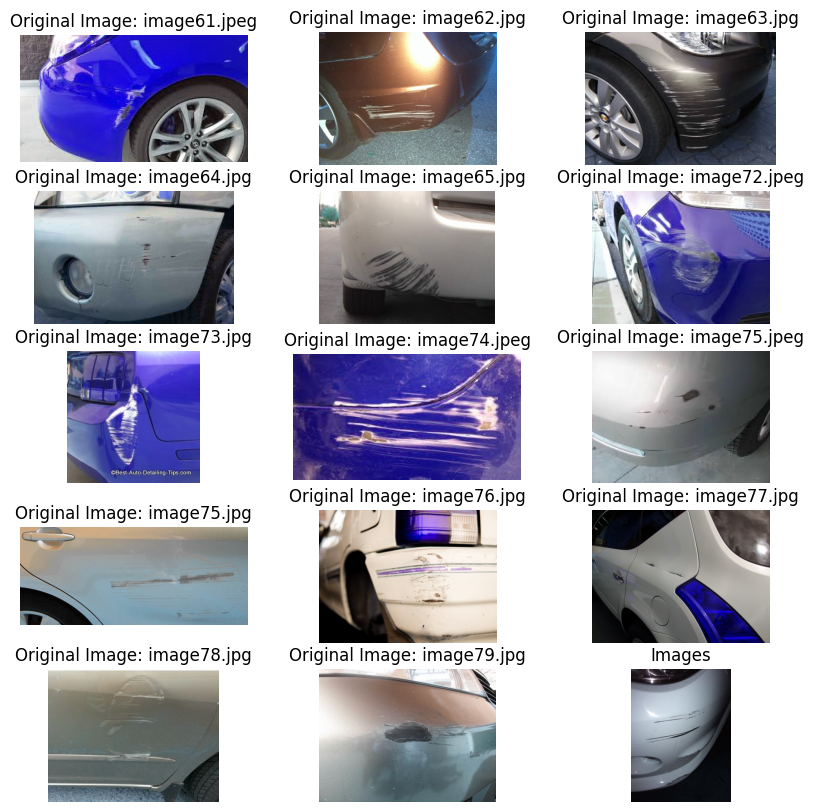

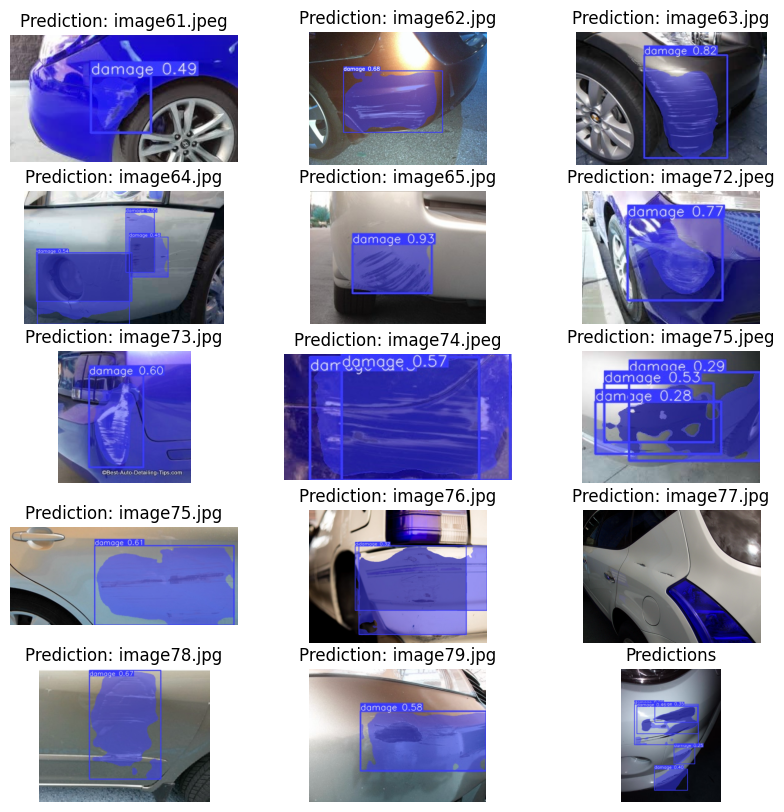

In [123]:
imgs = [i.split(sep = "\\")[-1] for i in val_list] # Create a list with all the image names within the validation directory
fig, ax = plt.subplots(figsize = (10,10), nrows = 5, ncols = 3) # Create a subplot to plot the original images
# Iterating through each image
for i,j in zip(imgs, ax.flatten()):
    results = model.predict(f"Dataset/val/{i}", save = True, save_dir = "runs/segment/predict4") # Predicting the car damage and saving the image to a directory
    j.imshow(cv2.imread(f"Dataset/val/{i}")) # Plot the original image
    j.set_title(f"Original Image: {i}") # Configure the title of the image
    j.axis("off") # Removing the axis
plt.title("Images") # Title of the entire plot

fig, ax = plt.subplots(figsize = (10,10), nrows = 5, ncols = 3) # Create a subplot to plot the predicted images
# Iterating over each predicted image
for i,j in zip(imgs, ax.flatten()):
    j.imshow(cv2.imread(f"runs/segment/predict4/{i}"))# Reading the predicted image
    j.set_title(f"Prediction: {i}") # Configure the title of the image
    j.axis("off") # Removing the axis
plt.title("Predictions") # Title of the entire plot
plt.show()

Both MaskRCNN and YOLO segmentation model performs well in detecting scratches, dents or any damage on the car from an image.

## Future Scope

1. This model can further be utilized to detect car damages using live video feed. **Current Challenge**: Limited computation available
2. Model can be trained on more images, conditions and epochs for better results. **Current Challenge**: Limited Data available (with annotations)